In [1]:
import os
import pickle
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# Realizar Grid Search
from itertools import product



# Seed all possible
seed_ = 935115
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)

# If using CUDA, you can set the seed for CUDA devices as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)
    
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:

# Load the data
data = pd.read_csv('../data/PROCESS/encoded_tch_prediction_data_zafrav3.2.csv')
data

,ABS_IDCOMP,ZAFRA,TCH,area,numero_corte,ETP_Q1_mean,ETP_Q1_sum,ETP_Q1_std,ETP_Q2_std,Radiacion (MJ/m2)_Q1_mean,...,sist_riego_goteo,sist_riego_gravedad,sist_riego_pivote,sist_riego_sin riego,tipo_cosecha_MANUAL,region,estrato,estacion,variedad,cuadrante
0,GT01-0010123-0310,20-21,160.600421,9.31,4.0,6.222039,0.755925,0.495493,0.860562,19.278630,...,0.0,0.0,0.0,0.0,1.0,5.0,3.0,14.0,5.0,7.0
1,GT01-0010594-0301,23-24,160.563622,25.07,15.0,4.737816,0.191868,0.272821,0.642679,19.434528,...,0.0,0.0,0.0,1.0,0.0,7.0,2.0,8.0,27.0,10.0
2,GT01-0010056-0601,21-22,159.977703,26.91,3.0,5.492823,0.889775,0.591866,0.636987,19.589984,...,0.0,0.0,1.0,0.0,0.0,6.0,2.0,13.0,5.0,12.0
3,GT01-0010056-0601,21-22,159.977703,26.91,3.0,5.492823,0.889775,0.591866,0.636987,19.589984,...,0.0,0.0,1.0,0.0,0.0,6.0,2.0,13.0,5.0,12.0
4,GT01-0010056-0501,23-24,159.961945,9.46,4.0,5.892769,0.954562,0.599341,0.598366,21.270083,...,0.0,0.0,0.0,0.0,0.0,6.0,2.0,13.0,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13280,GT01-0010051-2703,21-22,50.593750,7.68,4.0,4.984360,0.403705,0.625089,0.578224,17.000186,...,0.0,0.0,0.0,0.0,1.0,6.0,0.0,5.0,39.0,2.0
13281,GT01-0010802-0101,23-24,50.573913,11.50,7.0,5.403576,0.000000,0.568449,0.672121,18.650659,...,0.0,0.0,0.0,1.0,1.0,3.0,3.0,6.0,27.0,5.0
13282,GT01-0010647-0801,23-24,50.414676,5.86,5.0,3.831226,0.465461,0.629008,0.667664,15.746557,...,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,39.0,0.0
13283,GT01-0010827-0201,23-24,50.348000,15.00,1.0,3.580532,0.278117,1.617101,2.199564,13.957886,...,0.0,0.0,0.0,1.0,1.0,7.0,0.0,6.0,35.0,2.0


In [3]:

# Crear grupos de TCH
min_tch = int(data['TCH'].min())-1
max_tch = int(data['TCH'].max()) +1
bins = np.arange(min_tch, max_tch + 2, 2)
labels = [f'{i}-{i+2}' for i in bins[:-1]]
data['TCH_grupo'] = pd.cut(data['TCH'], bins=bins, labels=labels, include_lowest=True)

# Imprimir los grupos
print("Grupos de TCH:")
print(data['TCH_grupo'].value_counts().sort_index())
TCH_GRUP =  data['TCH_grupo'].value_counts().count()
print('TOTAL GRUPOS: ',TCH_GRUP)
# Create a mask for ZAFRA 22-23
mask_22_23 = data['ZAFRA'] == '23-24'

# Split the data
X_train_zafra = data[~mask_22_23].drop(['TCH', 'TCH_grupo','ABS_IDCOMP','ZAFRA'], axis=1)
X_test_zafra = data[mask_22_23].drop(['TCH', 'TCH_grupo','ABS_IDCOMP','ZAFRA'], axis=1)
y_train_zafra = data[~mask_22_23]['TCH_grupo']
y_test_zafra = data[mask_22_23]['TCH_grupo']

print("\nZAFRA Split:")
print(f"Training set shape: {X_train_zafra.shape}")
print(f"Testing set shape: {X_test_zafra.shape}")

data[~mask_22_23].to_csv('../data/UP/TRAIN.csv')
data[mask_22_23]['TCH_grupo'].to_csv('../data/UP/TEST.csv')

TCH_GRUP

Grupos de TCH:
TCH_grupo
49-51        7
51-53       38
53-55       40
55-57       47
57-59       56
59-61       80
61-63       87
63-65       94
65-67      136
67-69      174
69-71      216
71-73      196
73-75      210
75-77      253
77-79      302
79-81      289
81-83      371
83-85      368
85-87      403
87-89      413
89-91      445
91-93      478
93-95      508
95-97      460
97-99      474
99-101     458
101-103    518
103-105    546
105-107    500
107-109    438
109-111    457
111-113    443
113-115    389
115-117    316
117-119    360
119-121    397
121-123    329
123-125    235
125-127    239
127-129    242
129-131    214
131-133    152
133-135    182
135-137    116
137-139     89
139-141    100
141-143     75
143-145     62
145-147     75
147-149     39
149-151     41
151-153     45
153-155     20
155-157     39
157-159     14
159-161     10
Name: count, dtype: int64
TOTAL GRUPOS:  56

ZAFRA Split:
Training set shape: (11480, 93)
Testing set shape: (1805, 93)


56

In [4]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_zafra)
X_test_scaled = scaler.transform(X_test_zafra)


In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the encoder and transform the labels
le.fit(y_train_zafra)
y_train_encoded = le.transform(y_train_zafra)
y_test_encoded = le.transform(y_test_zafra)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Now your tensors are ready for training
X_train = X_train_tensor 
y_train = y_train_tensor
X_test = X_test_tensor
y_test = y_test_tensor


In [6]:

# Clase Net (la misma que proporcioné antes)
class ClassNet(nn.Module):
    def __init__(self, input_size,output_size,N=16):
        super(ClassNet, self).__init__()
        
        
          # Número total de capas lineales
        
        # Definir el tamaño máximo como un múltiplo del tamaño de entrada
        peak_size = input_size * 4  # Ajustar el multiplicador según sea necesario
        
        # Inicializar la lista de tamaños de capas
        layer_sizes = []
        
        # Capas ascendentes
        for i in range(N // 2):
            size = input_size + int((peak_size - input_size) * (i + 1) / (N // 2))
            layer_sizes.append(size)
        
        # Capas descendentes
        for i in range(N // 2):
            size = peak_size - int((peak_size - output_size) * (i + 1) / (N // 2))
            layer_sizes.append(size)
        
        # Definir las capas
        self.layers = nn.ModuleList()
        prev_size = input_size
        for size in layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
        self.layers.append(nn.Linear(prev_size, output_size))  # Capa de salida
        
        # Activaciones
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        N = len(self.layers)
        for i, layer in enumerate(self.layers[:-1]):  # Excluir la última capa
            x = layer(x)
            
            # Activaciones: sigmoid al principio, luego leaky ReLU, luego ReLU
            if i < N // 3:
                x = self.sigmoid(x)
            elif i < 2 * N // 3:
                x = self.leaky_relu(x)
            else:
                x = self.relu(x)
            
            # Dropout cada dos capas ocultas
            if (i + 1) % 2 == 0:
                x = self.dropout(x)
        
        # Capa final sin activación (para regresión)
        x = self.layers[-1](x)
        return x

    # Función de pérdida L1
    def l1_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return l1_loss

    # Función de pérdida L2
    def l2_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.sum(param.pow(2))
        return l2_loss


In [7]:
# Definir una función para entrenar el modelo con hiperparámetros específicos para clasificación
def train_model(model, criterion, optimizer, scheduler,
                X_train, y_train, X_val, y_val,
                num_epochs=100, l1_lambda=0.01, l2_lambda=0.01,
                early_stopping_patience=10, batch_size=32, writer=None):

    # Inicializar variables para early stopping
    global best_model_state
    best_val_loss = np.inf
    patience_counter = 0

    # Crear DataLoader para manejo de batches
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            l1_reg = l1_lambda * model.l1_loss()
            l2_reg = l2_lambda * model.l2_loss()
            loss = loss + l1_reg + l2_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Calcular precisión de entrenamiento en el batch
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        train_accuracy = correct / total
        
        # Actualizar el learning rate
        scheduler.step()
        
        # Evaluación en validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy = (val_predicted == y_val).sum().item() / y_val.size(0)
        
        # Registrar en TensorBoard
        if writer:
            writer.add_scalar('Loss/train', epoch_loss / len(train_loader), epoch)
            writer.add_scalar('Loss/val', val_loss.item(), epoch)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)
            writer.add_scalar('Accuracy/val', val_accuracy, epoch)
            writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch)
        
        # Early Stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            # Guardar el mejor modelo
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Mostrar métricas cada 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {scheduler.get_last_lr()[0]:.6f}, Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Cargar el mejor modelo
    model.load_state_dict(best_model_state)
    
    return model


In [8]:

# Definir los hiperparámetros para el Grid Search
param_grid = {
    'learning_rate': [0.01, 0.001],
    'l1_lambda': [0.0, 0.001],
    'l2_lambda': [0.0, 0.001],
    'batch_size': [2048],
    'num_epochs': [200],
    'optimizer_type': ['Adam', 'SGD'],
    'N': [16]
}
# Obtener todas las combinaciones de hiperparámetros
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_combinations = [dict(zip(keys, combination)) for combination in product(*values)]

best_model = None
best_val_accuracy = -np.inf
best_params = None
best_model_params = {}

In [9]:
# Función para calcular la precisión (accuracy)
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy


In [31]:

# Realizar Grid Search
for params in param_combinations:
    print(f"Evaluating combination: {params}")
    
    # Crear nuevo modelo
    input_size = X_train_tensor.shape[1]
    output_size = TCH_GRUP
    model = ClassNet(input_size,output_size,16)  # Asegúrate de que la clase Net esté definida para clasificación
    
    # Definir criterio y optimizador según los parámetros
    criterion = nn.CrossEntropyLoss()  # Cambiado para clasificación
    
    if params['optimizer_type'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer_type'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Inicializar TensorBoard
    writer = SummaryWriter(comment=f"LR_{params['learning_rate']}_L1_{params['l1_lambda']}_L2_{params['l2_lambda']}_BS_{params['batch_size']}_OPT_{params['optimizer_type']}")
    
    # Entrenar el modelo
    trained_model = train_model(
        model, criterion, optimizer, scheduler,
        X_train_tensor, y_train_tensor,
        X_test_tensor, y_test_tensor,
        num_epochs=params['num_epochs'],
        l1_lambda=params['l1_lambda'],
        l2_lambda=params['l2_lambda'],
        batch_size=params['batch_size'],
        writer=writer
    )
    
    # Evaluar en el conjunto de validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_accuracy = calculate_accuracy(y_test_tensor, val_outputs)  # Calcular precisión
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Cerrar el escritor de TensorBoard
    writer.close()
    
    # Guardar el mejor modelo
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = trained_model
        best_params = params
        best_model_params['input_size'] = input_size
        best_model_params['output_size'] = output_size
        best_model_params['N'] = params['N']
        

print(f"Best Validation Accuracy: {best_val_accuracy:.4f} with parameters {best_params}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_accuracy = calculate_accuracy(y_test_tensor, test_outputs)  # Precisión en conjunto de prueba
    test_loss = nn.CrossEntropyLoss()(test_outputs, y_test_tensor)  # Cambiado para CrossEntropyLoss

print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}")

In [10]:
# Parámetros específicos
params = {
    'learning_rate': 0.001,
    'l1_lambda': 0.0,
    'l2_lambda': 0.0,
    'batch_size': 2048,
    'num_epochs': 200,
    'optimizer_type': 'Adam',
    'N':16
}

# Crear el modelo
input_size = X_train_tensor.shape[1]
output_size = TCH_GRUP  # Asegúrate de que esta variable esté definida correctamente
model = ClassNet(input_size, output_size,N=16)

# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()

if params['optimizer_type'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
elif params['optimizer_type'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Inicializar TensorBoard
writer = SummaryWriter(comment=f"CLNN_LR_{params['learning_rate']}_L1_{params['l1_lambda']}_L2_{params['l2_lambda']}_BS_{params['batch_size']}_OPT_{params['optimizer_type']}")

# Entrenar el modelo
trained_model = train_model(
    model, criterion, optimizer, scheduler,
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    num_epochs=params['num_epochs'],
    l1_lambda=params['l1_lambda'],
    l2_lambda=params['l2_lambda'],
    batch_size=params['batch_size'],
    writer=writer
)

best_model_params['input_size'] = int(input_size)
best_model_params['output_size'] = int(output_size)
best_model_params['N'] = params['N']


Early stopping at epoch 25


In [11]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_accuracy = calculate_accuracy(y_test_tensor, test_outputs)
    _, predicted_labels = torch.max(test_outputs, 1)

print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 3.8602, Test Accuracy: 0.0211


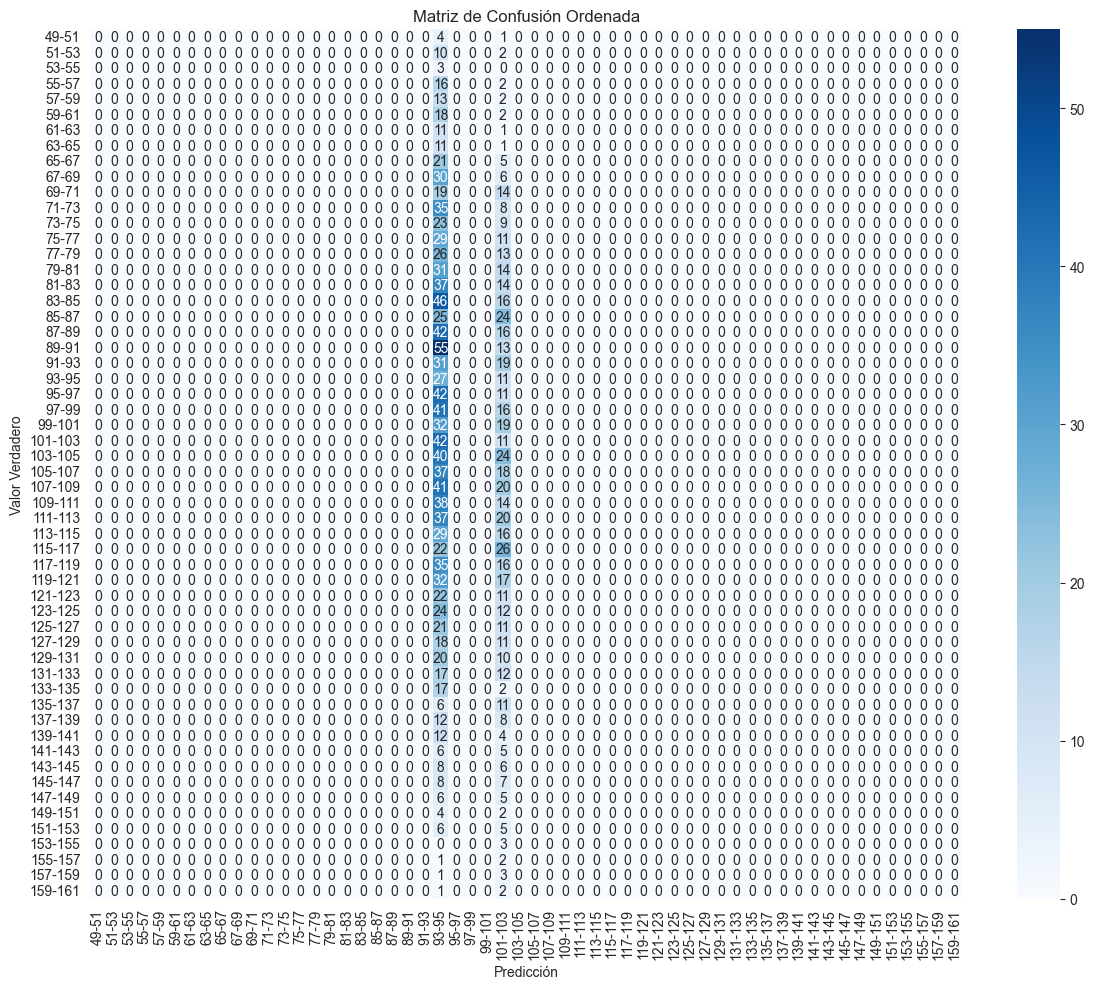

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_tensor.cpu(), predicted_labels.cpu())

# Obtener las etiquetas de clase ordenadas numéricamente
class_labels = le.classes_
class_labels = list(class_labels)

# Función para extraer el número inicial del rango
def get_starting_number(label):
    return int(label.split('-')[0])

# Ordenar las etiquetas de clase basándose en el número inicial
class_labels_sorted = sorted(class_labels, key=get_starting_number)

# Crear un mapeo de etiqueta de clase a entero
class_label_to_int = {label: i for i, label in enumerate(le.classes_)}

# Obtener los índices de etiquetas ordenados
sorted_int_labels = [class_label_to_int[label] for label in class_labels_sorted]

# Reordenar la matriz de confusión
conf_matrix_sorted = conf_matrix[np.ix_(sorted_int_labels, sorted_int_labels)]

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear un mapa de calor para la matriz de confusión ordenada
sns.heatmap(conf_matrix_sorted, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_sorted, yticklabels=class_labels_sorted)

# Configurar las etiquetas de los ejes
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.title('Matriz de Confusión Ordenada')

# Rotar las etiquetas de los ejes x si es necesario
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

In [53]:
TCH_GRUP

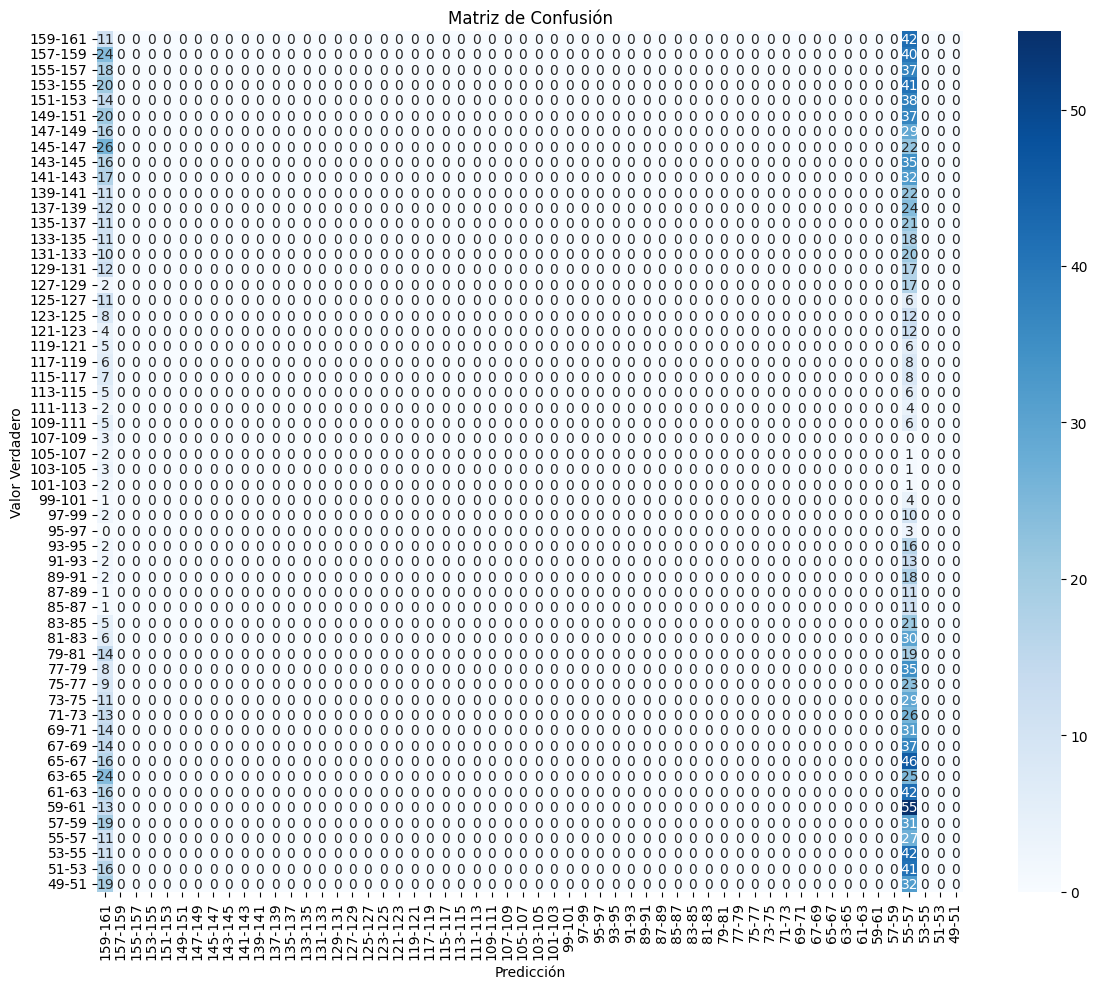

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_tensor.cpu(), predicted_labels.cpu())

# Si tienes nombres de clases, puedes definirlos así:
# Supongamos que tienes N clases
class_names = data['TCH_grupo'].unique()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según sea necesario

# Crear un mapa de calor (heatmap) para la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Configurar las etiquetas de los ejes
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.title('Matriz de Confusión')

# Rotar las etiquetas de los ejes x si es necesario
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()  # Ajusta el diseño para que todo encaje bien

plt.show()


C:\Users\angel\AppData\Local\Temp\ipykernel_44208\1449348434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grupo_counts.index, y=grupo_counts.values, palette='viridis')


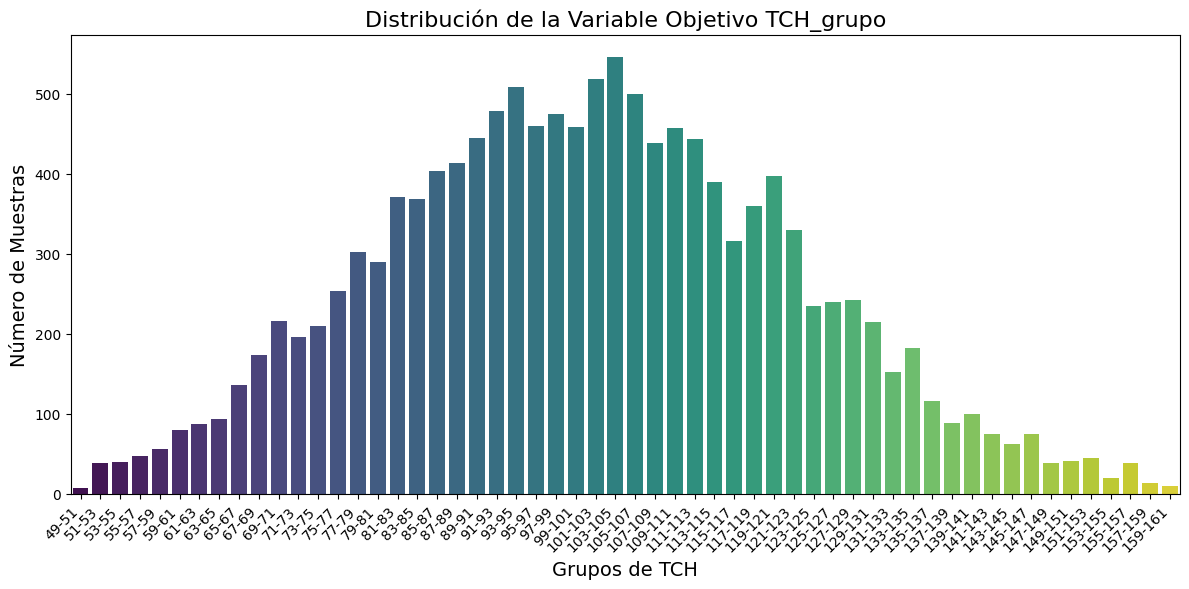

In [14]:
# Suponiendo que ya has ejecutado el código que crea 'TCH_grupo' en 'data'

# Contar la cantidad de muestras en cada grupo
grupo_counts = data['TCH_grupo'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=grupo_counts.index, y=grupo_counts.values, palette='viridis')

# Configurar las etiquetas y título
plt.xlabel('Grupos de TCH', fontsize=14)
plt.ylabel('Número de Muestras', fontsize=14)
plt.title('Distribución de la Variable Objetivo TCH_grupo', fontsize=16)

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# GUARDAR MODELO

In [67]:


# Define the directory where models will be saved
models_dir = '../models'

# Ensure the models directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


existing_dirs = [
    d for d in os.listdir(models_dir)
    if os.path.isdir(os.path.join(models_dir, d)) and d.startswith('CLNN_')
]

# Extract the numbers from existing CNN_# directories
numbers = []
for d in existing_dirs:
    try:
        num = int(d.split('_')[1])
        numbers.append(num)
    except ValueError:
        pass  # Ignore directories that don't fit the pattern

# Determine the next available number
next_num = max(numbers) + 1 if numbers else 1

# Create the new subdirectory
model_subdir = f'CLNN_{next_num}'
model_path = os.path.join(models_dir, model_subdir)
#model_path = models_dir+'/'+ model_subdir
os.makedirs(model_path)

print(f"Saving models in directory: {model_path}")



In [63]:
print(best_model_params)

In [68]:
import json

# Save the trained model
model_save_path = os.path.join(model_path, 'model.pth')
torch.save(trained_model.state_dict(), model_save_path)

# Save the scaler
scaler_save_path = os.path.join(model_path, 'scaler.pkl')
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
le_save_path = os.path.join(model_path, 'label_encoder.pkl')
with open(le_save_path, 'wb') as f:
    pickle.dump(le, f)

model_params_save_path = os.path.join(model_path, 'model_params.json')
with open(model_params_save_path, 'w') as f:
    json.dump(best_model_params, f)

print("Model, scaler, and label encoder have been saved successfully.")